<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Classifier-Comparison" data-toc-modified-id="Classifier-Comparison-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Classifier Comparison</a></span><ul class="toc-item"><li><span><a href="#Single-Classifier" data-toc-modified-id="Single-Classifier-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Single Classifier</a></span></li><li><span><a href="#Combined-Classifiers" data-toc-modified-id="Combined-Classifiers-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Combined Classifiers</a></span></li></ul></li><li><span><a href="#Performance-Analysis" data-toc-modified-id="Performance-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Performance Analysis</a></span></li><li><span><a href="#t-SNE-plots" data-toc-modified-id="t-SNE-plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>t-SNE plots</a></span></li></ul></div>

# Anomaly Detection

Anomaly detection is the process of identifying items in datasets that differ from the norm. Cancerous thermograms have structural and physiological differences compared to healthy explorations. Thus, I hypothesize that anomaly detection techniques will be useful in identifying suspicious thermograms. Since anomaly detection is unsupervised, I will use both training and unlabeled data to train the model and assign the probability of being an outlier to each observation in the dataset. Some of this work is based on tutorials provided in the PyOD documentation: https://pyod.readthedocs.io/en/latest/example.html

In [1]:
# Environment Setup
from utils import *
plt.style.use('default')

Progress: [###################-] 97.3%


In [2]:
# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

## Data Preparation

In [3]:
# Data
X = pd.read_csv('train_data.csv')
X_test = pd.read_csv('test_data.csv')
X_val = pd.read_csv('val_data.csv')
# Unlabeled data
X_blind = pd.read_csv('blind_data.csv')
X_blind['BIRADS'] = -1

# Targets
birads = X['BIRADS'].values
y = np.where(X['BIRADS'].values>3, 1, 0)
birads_test = X_test['BIRADS'].values
y_test = np.where(X_test['BIRADS'].values>3, 1, 0)
y_val = np.where(X_val['BIRADS'].values>3, 1, 0)
y_blind = X_blind.BIRADS.values

# Drop irrelevant columns
X = X.drop(columns=['BIRADS','PID'])
X_test = X_test.drop(columns=['BIRADS', 'PID'])
birads_val = X_val.BIRADS.values
X_val = X_val.drop(columns=['BIRADS', 'PID'])
X_blind = X_blind.drop(columns=['BIRADS','PID'])

# Get model
parameters = pickle.load(open( "params.pkl", "rb"))

In [4]:
# Helper function
def normalize(X_train, X_test=[]):
    ''' Normalize train and test data from 0 to 1. 
    
    Inputs
    ----------
    train: pandas dataframe
         Train data in tabular format
    test: pandas dataframe (optional)
         Test data in tabular format
        
    Returns
    -------
    Dataframes with columns normalized from 0 to 1
    '''
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std = np.where(std!=0, std, 1)
    
    X_train = (X_train-mean)/std
    X_train = np.nan_to_num(X_train)
    if  len(X_test)==0:
        return X_train
    else:
        X_test = (X_test-mean)/std
        X_test = np.nan_to_num(X_test)
        return X_train, X_test

In [5]:
# Stack data for unsupervised methods
X_train_full = np.vstack([X, X_blind])
y_train_full = np.hstack([y, y_blind])

## Classifier Comparison

### Single Classifier

In [6]:
# Evaluate the fraction of positive samples
outliers_fraction = np.round(sum(y)/len(y), 2)
print('Fraction of outliers: ', outliers_fraction)

# Specify outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,
                                         check_estimator=False),
        'Isolation Forest': IForest(contamination=outliers_fraction),
        'K-Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        'Feature Bagging_50': FeatureBagging(base_estimator=None,
                                             n_estimators=50, 
                                             contamination=outliers_fraction, 
                                             max_features=1.0,
                                             bootstrap_features=True,
                                             check_detector=True,
                                             check_estimator=True, n_jobs=1,
                                             random_state=None, combination='max', 
                                             verbose=0, estimator_params=None),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,
                                                           check_estimator=False,
                                                           n_clusters=10),     
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction)}

Fraction of outliers:  0.06


In [7]:
def get_preds(X_train, X_test, y_test, classifiers):
    ''' Fit anomaly detection model and make predicitons.
    
    Inputs
    ----------
    X_train: pandas dataframe
         Train data in tabular format
    X_test: pandas dataframe
         Test data in tabular format
    y_test: numpy array
         List of test targets
    classifiers: dictionary
         Dictionary of classifier names and functions
        
    Returns
    -------
    Evaluation scores for differen methods
    '''
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(normalize(X_train))
        train_score = clf.decision_scores_
        test_score = clf.decision_function(normalize(X_test))
        # Evaluate results
        evaluate_print(clf_name, y_test, test_score)

In [8]:
# Evaluate different methods
get_preds(X_train_full, X_val, y_val, classifiers)

Angle-based Outlier Detector (ABOD) ROC:0.6418, precision @ rank n:0.1739
Feature Bagging ROC:0.6827, precision @ rank n:0.2174
Isolation Forest ROC:0.6459, precision @ rank n:0.1739
K-Nearest Neighbors (KNN) ROC:0.6433, precision @ rank n:0.2609
Average KNN ROC:0.6441, precision @ rank n:0.2174
Feature Bagging_50 ROC:0.5979, precision @ rank n:0.1304
Cluster-based Local Outlier Factor (CBLOF) ROC:0.6791, precision @ rank n:0.2174
Histogram-base Outlier Detection (HBOS) ROC:0.6604, precision @ rank n:0.1304


### Combined Classifiers

Outlier detection often suffers from model instability due to its unsupervised nature. Thus, it is recommended to
combine various detector outputs, e.g., by averaging, to improve robustness. Detector combination is a subfield of outlier ensembles. The PyOD library has built-in methods for combining different classifiers.

In [9]:
# Number of base detectors
n_clf = 20  

# Try different variations of the best performing classifier
# along with other classifiers
k_list = [10,30,60,90,100,
          120,150,160,180,
          210,240,270, 300]

train_scores = np.zeros([X.shape[0], n_clf])
val_scores = np.zeros([X_val.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

print('Initializing {n_clf} detectors:'.format(n_clf=n_clf))

for i in range(12):
    k = k_list[i]
    # Get predictions with different n_estimators
    clf = FeatureBagging(base_estimator=None,
                        n_estimators=k, 
                        contamination=outliers_fraction, 
                        max_features=1.0,
                        bootstrap_features=True,
                        check_detector=True,
                        check_estimator=True, n_jobs=1,
                        random_state=None, combination='max', 
                        verbose=0, estimator_params=None)
    clf.fit(normalize(X))

    train_scores[:, i] = clf.decision_scores_
    val_scores[:, i] = clf.decision_function(normalize(X, X_val)[1])
    test_scores[:, i] = clf.decision_function(normalize(X, X_test)[1])
    print('Base detector %i is fitted for prediction' % (i+1))

# Also add other classifiers
for i, (clf_name, clf) in enumerate(classifiers.items()):
    i+=12
    clf.fit(normalize(X))

    train_scores[:, i] = clf.decision_scores_
    val_scores[:, i] = clf.decision_function(normalize(X, X_val)[1])
    test_scores[:, i] = clf.decision_function(normalize(X, X_test)[1])
    print('Base detector %i is fitted for prediction' % (i+1))

Initializing 20 detectors:
Base detector 1 is fitted for prediction
Base detector 2 is fitted for prediction
Base detector 3 is fitted for prediction
Base detector 4 is fitted for prediction
Base detector 5 is fitted for prediction
Base detector 6 is fitted for prediction
Base detector 7 is fitted for prediction
Base detector 8 is fitted for prediction
Base detector 9 is fitted for prediction
Base detector 10 is fitted for prediction
Base detector 11 is fitted for prediction
Base detector 12 is fitted for prediction
Base detector 13 is fitted for prediction
Base detector 14 is fitted for prediction
Base detector 15 is fitted for prediction
Base detector 16 is fitted for prediction
Base detector 17 is fitted for prediction
Base detector 18 is fitted for prediction
Base detector 19 is fitted for prediction
Base detector 20 is fitted for prediction


In [10]:
# Normalize before combination
train_scores_norm, val_scores_norm = standardizer(train_scores,
                                                   val_scores)
_, test_scores_norm = standardizer(train_scores, 
                                   test_scores)

print('Decision score matrix on training data', train_scores_norm.shape)
print('Decision score matrix on validation data', val_scores_norm.shape)
print('Decision score matrix on test data', test_scores_norm.shape)

Decision score matrix on training data (1116, 20)
Decision score matrix on validation data (372, 20)
Decision score matrix on test data (373, 20)


In [11]:
# Combination by average
y_by_average = average(val_scores_norm)
evaluate_print('Combination by Average', y_val, y_by_average)

# Combination by max
y_by_maximization = maximization(val_scores_norm)
evaluate_print('Combination by Maximization', y_val, y_by_maximization)

# Combination by aom
y_by_aom = aom(val_scores_norm, n_buckets=4)
evaluate_print('Combination by AOM', y_val, y_by_aom)

# Combination by moa
y_by_moa = moa(val_scores_norm, n_buckets=4)
evaluate_print('Combination by MOA', y_val, y_by_moa)

Combination by Average ROC:0.6562, precision @ rank n:0.1739
Combination by Maximization ROC:0.6255, precision @ rank n:0.1739
Combination by AOM ROC:0.642, precision @ rank n:0.1739
Combination by MOA ROC:0.6473, precision @ rank n:0.1739


In [12]:
# Get train scores as well
y_avg_train = average(train_scores_norm)

# Combination by average test
y_avg_val = average(val_scores_norm)
y_avg_test = average(test_scores_norm)

## Performance Analysis

In [13]:
# Single classifier
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(normalize(X_full))
    X_single = pd.DataFrame.copy(pd.DataFrame(X))
    preds = clf.predict(normalize(X))
    X_single['out_det'] = preds
    X_val_single = pd.DataFrame.copy(pd.DataFrame(X_val))
    preds = clf.predict(normalize(X_full, X_val)[1])
    X_val_single['out_det'] = preds 
    X_test_single = pd.DataFrame.copy(pd.DataFrame(X_test))
    preds = clf.predict(normalize(X_full, X_test)[1])
    X_test_single['out_det'] = preds 
    print(clf_name, performance(X_single, y, 
                                X_val_single, 
                                y_val, model=MLPClassifier(**parameters)))

Angle-based Outlier Detector (ABOD) 0.7296623894356546
Feature Bagging 0.7042481624517254
Isolation Forest 0.6595241061417714
K-Nearest Neighbors (KNN) 0.6460695153855737
Average KNN 0.7157094805033013
Feature Bagging_50 0.6981437647938208
Cluster-based Local Outlier Factor (CBLOF) 0.617291640712595
Histogram-base Outlier Detection (HBOS) 0.7456085710726299


In [14]:
# Combined classifiers
X_combined = pd.DataFrame(X)
X_combined['out_det'] = y_avg_train
X_val_combined = pd.DataFrame(X_val)
X_val_combined['out_det'] = y_avg_val
X_test_combined = pd.DataFrame(X_test)
X_test_combined['out_det'] = y_avg_test
print('Combined classifiers')
performance(X_combined, y, X_val_combined,
            y_val, model=MLPClassifier(**parameters))

Combined classifiers


0.6589012084215772

## t-SNE plots

Use t-SNE plots to visualize the best-performing method.

In [15]:
# Set number of iterations
n_iter = int(4e3)
tsne = manifold.TSNE(n_components=2,
                     init='random',
                     learning_rate=10,
                     random_state=1,
                     perplexity=10,
                     early_exaggeration=20,
                     n_iter=n_iter,
                     n_iter_without_progress=n_iter//2,
                     metric='euclidean',
                     angle=0.2)

# Fit embedding
X_train_full = normalize(X_train_full)
embed = tsne.fit_transform(X_train_full)

In [16]:
df = pd.DataFrame(embed, columns=('X1','X2'))
scaler = MinMaxScaler(feature_range=(0, 1))
df[['X1','X2']] = scaler.fit_transform(df[['X1','X2']])
df.head()

targets = pd.DataFrame(y_train_full, 
                       columns = ['target'])

Outliers :  196 Inliers :  2796 Classifier:  Angle-based Outlier Detector (ABOD)


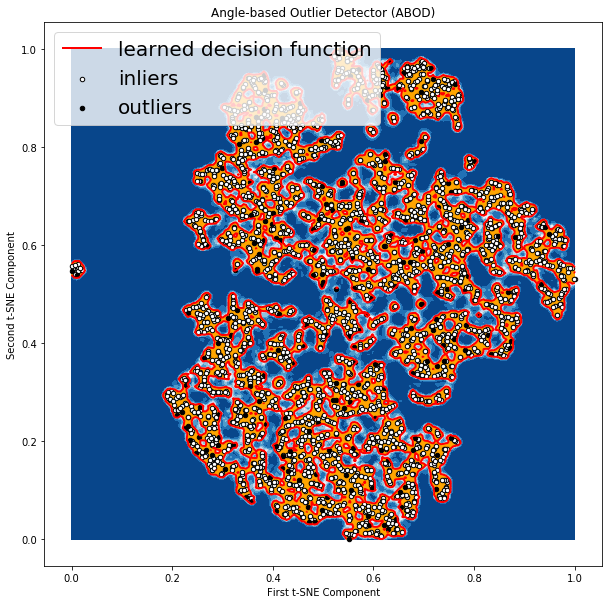

Outliers :  152 Inliers :  2840 Classifier:  Feature Bagging


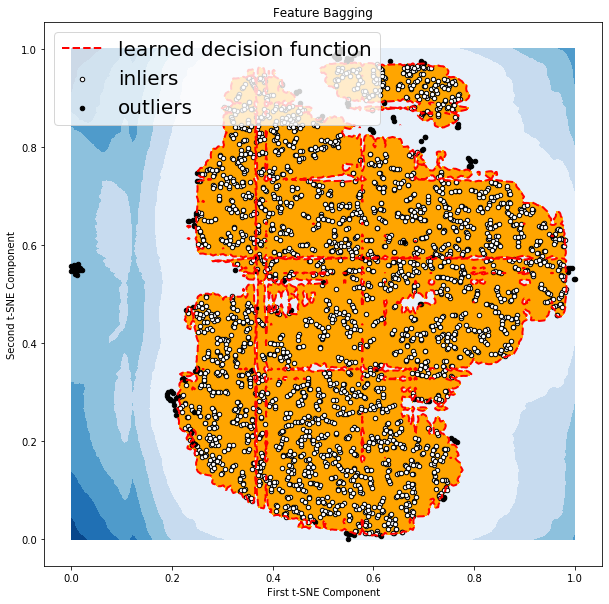

Outliers :  180 Inliers :  2812 Classifier:  Isolation Forest


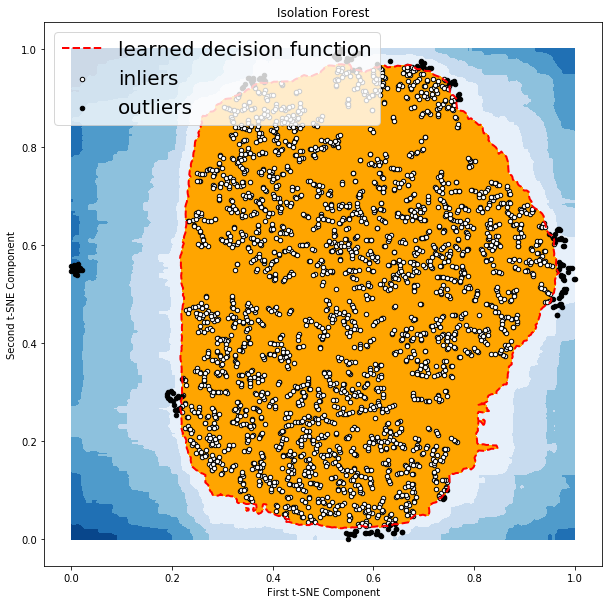

Outliers :  93 Inliers :  2899 Classifier:  K-Nearest Neighbors (KNN)


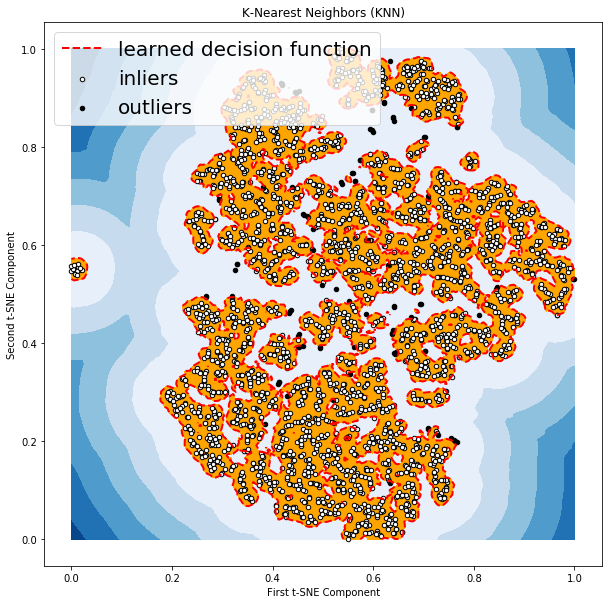

Outliers :  28 Inliers :  2964 Classifier:  Average KNN


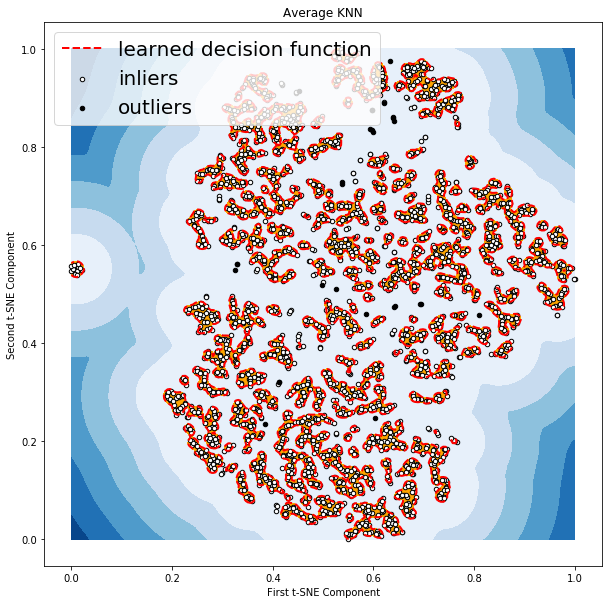

Outliers :  143 Inliers :  2849 Classifier:  Feature Bagging_50


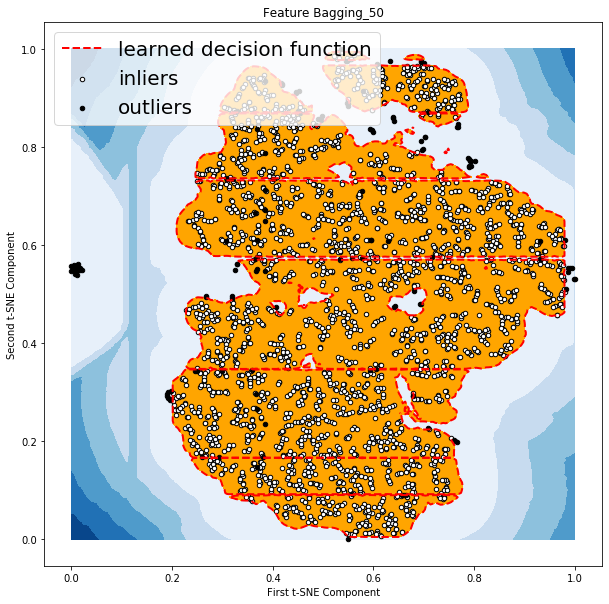

Outliers :  180 Inliers :  2812 Classifier:  Cluster-based Local Outlier Factor (CBLOF)


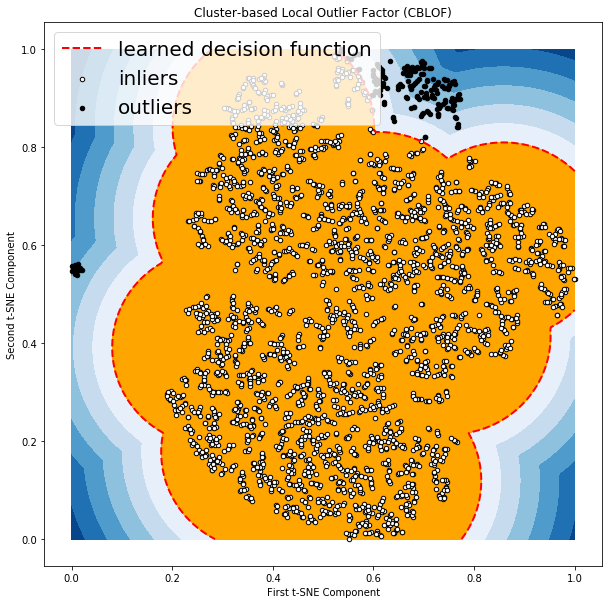

Outliers :  173 Inliers :  2819 Classifier:  Histogram-base Outlier Detection (HBOS)


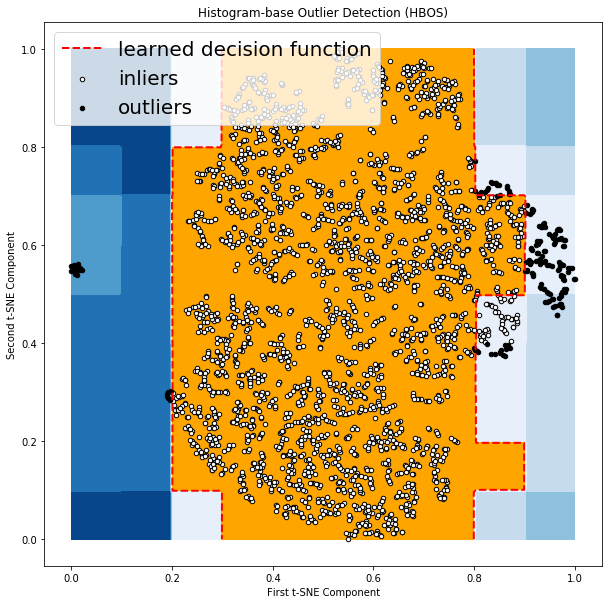

In [17]:
# Adapted from: https:
#//www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/
xx , yy = np.meshgrid(np.linspace(0,1, 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(df)
    # Predict raw anomaly score
    scores_pred = clf.decision_function(df) * -1
        
    # Prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(df)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred==1)
    plt.figure(figsize=(10, 10))
    

    targets[clf_name] = y_pred.tolist()
    
    IX1 =  np.array(df['X1'][targets[clf_name]==0]).reshape(-1,1)
    IX2 =  np.array(df['X2'][targets[clf_name]==0]).reshape(-1,1)
    OX1 =  df['X1'][targets[clf_name]==1].values.reshape(-1,1)
    OX2 =  df['X2'][targets[clf_name]==1].values.reshape(-1,1)
         
    print('Outliers : ',n_outliers,'Inliers : ',n_inliers, 'Classifier: ', clf_name)
        
    # Threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100*outliers_fraction)
    # Decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])*-1
    Z = Z.reshape(xx.shape)
    # Fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, 
                 levels=np.linspace(Z.min(), threshold, 7),
                 cmap=plt.cm.Blues_r)
        
    # Draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, 
                    levels=[threshold],
                    linewidths=2, 
                    colors='red')
        
    # Fill orange contour lines where range of anomaly score 
    # is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, 
                 levels=[threshold, Z.max()], 
                 colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',
                    s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',
                    s=20, edgecolor='k')
       
    
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers', 'outliers'],
        prop=mpl.font_manager.FontProperties(size=20),
        loc=2)
    plt.xlabel('First t-SNE Component')
    plt.ylabel('Second t-SNE Component') 
    plt.title(clf_name)
    plt.show()

                   pre       rec       spe        f1       geo       iba       sup

   Negative       0.95      0.97      0.17      0.96      0.41      0.18       350
   Positive       0.25      0.17      0.97      0.21      0.41      0.15        23

avg / total       0.90      0.92      0.22      0.91      0.41      0.18       373

                   pre       rec       spe        f1       geo       iba       sup

   Negative       0.94      0.96      0.09      0.95      0.29      0.09       350
   Positive       0.13      0.09      0.96      0.11      0.29      0.08        23

avg / total       0.89      0.91      0.14      0.90      0.29      0.09       373

                   pre       rec       spe        f1       geo       iba       sup

   Negative       0.95      0.97      0.17      0.96      0.41      0.18       350
   Positive       0.25      0.17      0.97      0.21      0.41      0.15        23

avg / total       0.90      0.92      0.22      0.91      0.41      0.18       

0.7356521739130436

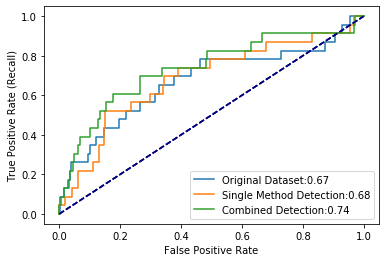

In [18]:
performance(X, y, X_test, y_test, detailed=True,
            report=True, title='Original Dataset', 
            model=MLPClassifier(**parameters))
performance(X_single, y, X_test_single, y_test, 
            detailed=True, report=True,
            title='Single Method Detection', 
            model=MLPClassifier(**parameters))
performance(X_combined, y, X_test_combined, y_test, 
            detailed=True, report=True,
            title='Combined Detection', 
            model=MLPClassifier(**parameters))

MLPClassifier(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


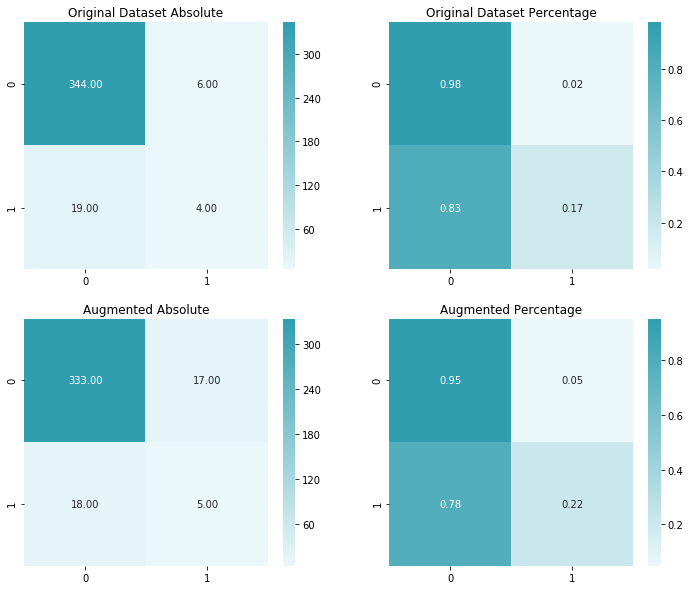

In [19]:
model = MLPClassifier(**parameters)
print(model)
conf_matrix_plot(X, y, 
                 X_single, y, 
                 X_test, X_test_single, 
                 y_test, y_test, 
                 model)

MLPClassifier(activation='tanh', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


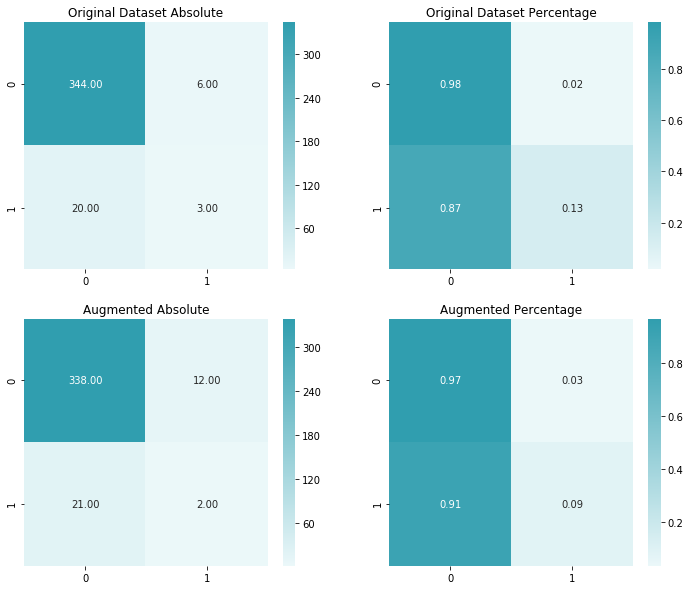

In [20]:
model = MLPClassifier(**parameters)
print(model)
conf_matrix_plot(X, y, 
                 X_combined, y, 
                 X_test, X_test_combined, 
                 y_test, y_test, 
                 model)

In [21]:
# Save data
X_single['BIRADS'] = birads
X_test_single['BIRADS'] = birads_test
X_single.to_csv('train_data_outliers.csv')
X_test_single.to_csv('test_data_outliers.csv')
X_val_single['BIRADS'] = birads_val
X_val_single.to_csv('val_data_outliers.csv')